### RAG powered Q & A for Insurellm employees
---------------------------------------------------------------------------

An internal expert knowledge assistant for Insurellm employees, using Retrieval-Augmented Generation (RAG) to deliver fast, accurate and cost efficient answers to a wide range of internal queries.

- TASK: Answer questions about Insurellm using naive RAG
- Models: OpenAI GPT via LangChain
- Retrieval: ChromaDB + OpenAI embeddings
- Tools:
  - langchain
  - openai
  - chromadb
  - gradio
  - python
- Features:
  - Loads PDF, text and markdown files automatically
  - Only updates when files actually changes (saves time)
  - Breaks documents into small, overlapping pieces for better search
  - Finds the most relevant information using smart matching
  - Remembers conversation history and shows where answers come from
  - Only answers based on your documents (no made-up information)
  - Web chat interface with streaming responses
  - Handles errors gracefully and detects duplicate content
  - Tracks document details and keeps everything organized
  - Ready for business use with built-in quality checks
- Output: Streaming response with sources retrieved from the knowledge base
- Hardware: CPU is sufficient - no GPU required
#### Requirements: OpenAI API key
#### Customizable by user
    - Modify system and expansion prompts
    - Drop in new company documents
    - Adjust retrieval top-k and similarity threshold
This project currently uses a naive RAG approach, which limits the assistant's performance and accuracy. To improve response quality and reliability, more advanced RAG techniques will be needed - a more refined and powerful version is planned for future release.

![Simple RAG Diagram](../images/naive_rag.png)


In [ ]:
## imports
# Standard library imports
import os
import hashlib
from pathlib import Path
from typing import List
import glob

# Third-party imports
import numpy as np
import plotly.graph_objects as go
from dotenv import load_dotenv
from pydantic import Field
from sklearn.manifold import TSNE
import gradio as gr

# LangChain core imports
from langchain.document_loaders import TextLoader, PyPDFLoader
from langchain.text_splitter import CharacterTextSplitter
from langchain.schema import BaseRetriever, Document
from langchain.schema.vectorstore import VectorStoreRetriever
from langchain.callbacks.manager import CallbackManagerForRetrieverRun
from langchain.memory import ConversationBufferMemory
from langchain.chains import ConversationalRetrievalChain
from langchain.prompts import PromptTemplate

# LangChain integrations
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_chroma import Chroma



#### Load env variables and configuration

In [ ]:
# Load the environment variables
load_dotenv(override=True)

# Configuration
DATA_PATH = "knowledge-base/"
MODEL = "gpt-4o-mini"
CHROMA_PATH = "vector_db/chroma_insurellm"

# Explicitly access the OpenAI API key
openai_api_key = os.getenv('OPENAI_API_KEY')
if not openai_api_key:
    print("❌ OPENAI_API_KEY is missing")

📄 Load files as Document objects into memory

In [ ]:
# Load .pdf, .txt and .md documents with metadata, excluding Jupyter checkpoints

documents = []

def add_metadata(doc, file_path):
    doc.metadata["doc_type"] = file_path.parent.name
    doc.metadata["file_name"] = file_path.name
    if not doc.page_content.strip():
        print(f"⚠️ Empty content in {file_path}")
    return doc

for file_path in Path(DATA_PATH).rglob("*"):
    if ".ipynb_checkpoints" in file_path.parts:
        continue
    try:
        if file_path.name.endswith(".pdf"):
            docs = PyPDFLoader(str(file_path)).load()
        elif file_path.name.endswith((".txt", ".md")):
            docs = TextLoader(str(file_path), encoding="utf-8").load()
        else:
            continue
    except Exception as e:
        print(f"❌ Skipped {file_path}: {e}")
        continue

    documents.extend([add_metadata(doc, file_path) for doc in docs])

print(f"{len(documents)} documents loaded." if documents else "No documents loaded.")
# print(documents[0])

#### ✂️ Splitting documents into chunks

In [ ]:
# Split documents into smaller chunks with overlapping characters for better context.
text_splitter = CharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=200,
    add_start_index=True # Maintain chunk order (useful for context tracking)
)

# Load and split documents
chunks = text_splitter.split_documents(documents)

print(f"Split {len(documents)} documents into {len(chunks)} chunks.")

def generate_chunk_id(text):
    return hashlib.md5(text.encode("utf-8")).hexdigest()

# Add chunk_id to each chunk's metadata
for chunk in chunks:
    chunk.metadata["chunk_id"] = generate_chunk_id(chunk.page_content) # Create an MD5 hash of the chunk's content
    if not chunk.page_content.strip():
        print(f"⚠️ Empty chunk from: {chunk.metadata['file_name']}")

# Debug: print a few chunk metadatas to verify chunk_id is added
for i, chunk in enumerate(chunks[:2]):
    print(f"Chunk {i+1} metadata:", chunk.metadata)

print("+"*100)

for chunk in chunks[:2]:
    print(chunk)
    print("\n\n")
        

In [ ]:
# Check for duplicate chunk IDs
chunk_ids = [chunk.metadata["chunk_id"] for chunk in chunks]
duplicate_ids = [chunk_id for chunk_id in chunk_ids if chunk_ids.count(chunk_id) > 1]

if duplicate_ids:
    print(f"Duplicate chunk IDs found: {duplicate_ids}")
else:
    print("No duplicate chunks.")

🧠 Chuncks Embedding

In [ ]:
embedding_function = OpenAIEmbeddings()
# By default, OpenAIEmbeddings() uses OpenAI's text-embedding-ada-002 model - a multilingual model

💾 Save embedded chunks to Chroma database

In [ ]:
os.makedirs(CHROMA_PATH, exist_ok=True)

def get_existing_chunk_ids(db_path):
    try:
        db_existing = Chroma(persist_directory=db_path)
        results = db_existing._collection.get(include=["metadatas"])
        return set(
            m["chunk_id"] for m in results["metadatas"]
            if isinstance(m, dict) and "chunk_id" in m
        )
    except Exception as e:
        print("❌ Error loading existing chunk IDs:", e)
        return set()

# Get chunk_ids of current chunks
new_chunk_ids = set([chunk.metadata["chunk_id"] for chunk in chunks])

# Get existing chunk_ids from Chroma
existing_chunk_ids = get_existing_chunk_ids(CHROMA_PATH)

# Compare
if new_chunk_ids != existing_chunk_ids:
    print("Chunk changes detected. Rebuilding Chroma DB.")
    db = Chroma.from_documents(documents=chunks, embedding=embedding_function, persist_directory=CHROMA_PATH)
    print(f"Saved {len(chunks)} chunks to {CHROMA_PATH}.")
else:
    db = Chroma(persist_directory=CHROMA_PATH, embedding_function=embedding_function)
    print("Chroma DB is up to date. Skipping regeneration.")

📊 Visualizing the Vector Store

In [ ]:
collection = db._collection
result = collection.get(include=['embeddings', 'documents', 'metadatas'])
vectors = np.array(result['embeddings'])
documents = result['documents']
metadatas = result['metadatas']
doc_types = [metadata['doc_type'] for metadata in metadatas]
# colors = [['blue', '#4B0082', 'red', '#8B4513'][['products', 'employees', 'contracts', 'company'].index(t)] for t in doc_types]
color_map = {
    'products': 'blue',
    'employees': '#4B0082',
    'contracts': 'red',
    'company': '#8B4513'
}

colors = [color_map[t] for t in doc_types]

In [ ]:
# We humans find it easier to visalize things in 2D!
# Reduce the dimensionality of the vectors to 2D using t-SNE
# (t-distributed stochastic neighbor embedding)

tsne = TSNE(n_components=2, random_state=42)
reduced_vectors = tsne.fit_transform(vectors)

# Create the 2D scatter plot
fig = go.Figure(data=[go.Scatter(
    x=reduced_vectors[:, 0],
    y=reduced_vectors[:, 1],
    mode='markers',
    marker=dict(size=8, color=colors, opacity=0.8),
    text=[f"Type: {t}<br>Text: {d[:100]}..." for t, d in zip(doc_types, documents)],
    hoverinfo='text'
)])

fig.update_layout(
    title='2D Chroma Vector Store Visualization',
    plot_bgcolor='black',
    paper_bgcolor='black',
    font=dict(color='black'),
    xaxis=dict(gridcolor='lightgray', zerolinecolor='lightgray'),
    yaxis=dict(gridcolor='lightgray', zerolinecolor='lightgray'),
    width=800,
    height=600,
    margin=dict(r=20, b=10, l=10, t=40),
)


fig.show()

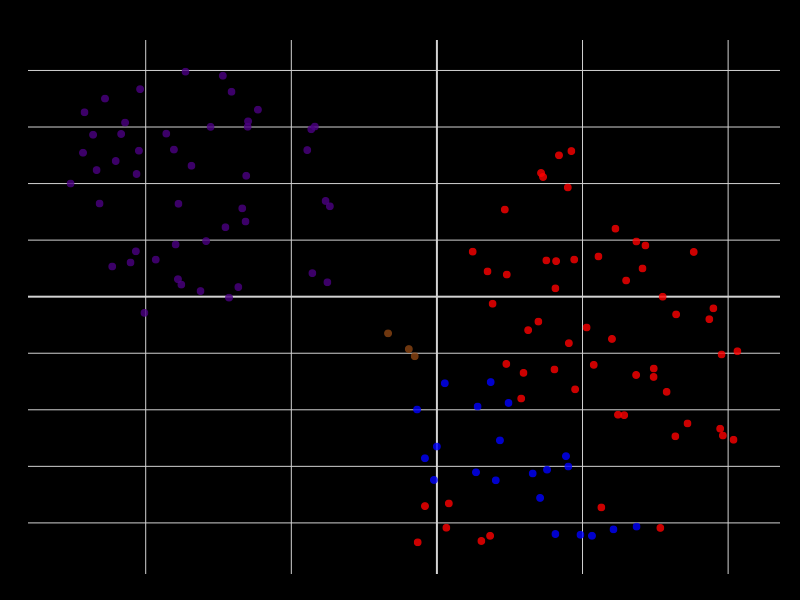

In [ ]:
# Let's try 3D!

tsne = TSNE(n_components=3, random_state=42)
reduced_vectors = tsne.fit_transform(vectors)

# Create the 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=reduced_vectors[:, 0],
    y=reduced_vectors[:, 1],
    z=reduced_vectors[:, 2],
    mode='markers',
    marker=dict(size=8, color=colors, opacity=0.8),
    text=[f"Type: {t}<br>Text: {d[:100]}..." for t, d in zip(doc_types, documents)],
    hoverinfo='text'
)])

fig.update_layout(
    title='3D Chroma Vector Store Visualization',
    plot_bgcolor='black',
    paper_bgcolor='black',
    font=dict(color='white'),
    scene=dict(
        xaxis=dict(color='white', backgroundcolor='black', showbackground=True),
        yaxis=dict(color='white', backgroundcolor='black', showbackground=True),
        zaxis=dict(color='white', backgroundcolor='black', showbackground=True)
    ),
    width=900,
    height=700,
    margin=dict(r=20, b=10, l=10, t=40)
)

fig.show()

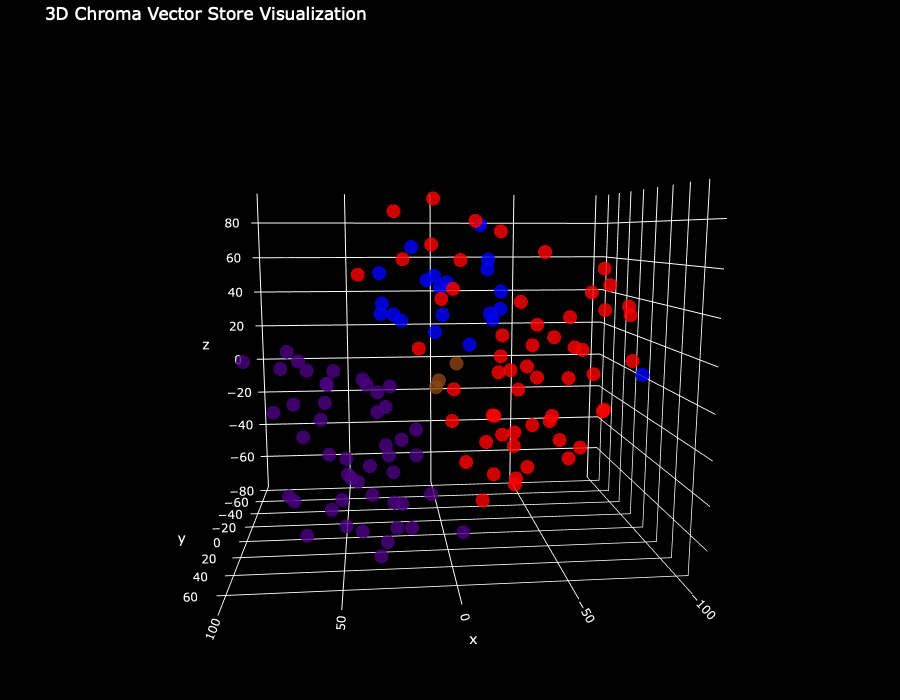

🔍 Query Chroma

In [ ]:
similarity_threshold = 0.5

class MyVectorStoreRetriever(VectorStoreRetriever):
    def _get_relevant_documents(
        self, query: str, *, run_manager: CallbackManagerForRetrieverRun
    ) -> List[Document]:
        docs_and_similarities = (
            self.vectorstore.similarity_search_with_relevance_scores(
                query, **self.search_kwargs
            )
        )

        # Make the score part of the document metadata
        for doc, similarity in docs_and_similarities:
            doc.metadata["score"] = similarity

        docs = [doc for doc, sim in docs_and_similarities if sim >= self.search_kwargs.get("score_threshold", 0)]
        return docs

retriever = MyVectorStoreRetriever(
   vectorstore=db,
   search_type="similarity_score_threshold",
   search_kwargs={"score_threshold": similarity_threshold, "k": 20},
)


# Add metadata to the context sentto the LLM
def inject_metadata(doc: Document) -> Document:
    doc_type = doc.metadata.get("doc_type", "Unknown")
    file_name = doc.metadata.get("file_name", "Unknown")
    content = f"[SOURCE: {doc_type} - {file_name}]\n{doc.page_content}"
    return Document(page_content=content, metadata=doc.metadata)

class MetadataInjectingRetriever(BaseRetriever):
    base_retriever: BaseRetriever = Field()

    def _get_relevant_documents(self, query: str):
        docs = self.base_retriever.get_relevant_documents(query)
        return [inject_metadata(doc) for doc in docs]

retriever = MetadataInjectingRetriever(base_retriever=retriever)

🗣️ LLM and answers

In [ ]:
llm = ChatOpenAI(temperature=0.7, model_name=MODEL)
memory = ConversationBufferMemory(memory_key='char_history', return_messages=True)

In [ ]:
# Define your question
question = "Who are the top 3 earners in 2023 with base, bonus, and total. Include names."

# Define the system prompt
system_prompt = """
You are an assistant that answers questions about the company Insurellm.

Use the following chat history and retrieved documents to answer.

Always base your answers strictly on the retrieved documents. If documents contain partial info, respond with what’s available. If there is no info, say so.

Do not invent names, roles, or facts.

You can use the document source information shown in the format [SOURCE: doc_type - file_name] if it helps you answer the question accurately.

Always extract exact numbers (like number of employees, years, revenue, etc.) from the documents if they are mentioned.


Chat History:
{chat_history}

Documents:
{context}

Question:
{question}
"""

# Create the prompt template
prompt = PromptTemplate(
    input_variables=["chat_history", "context", "question"],
    template=system_prompt
)

# Set up LLM, memory, and conversation chain
llm = ChatOpenAI(temperature=0.7, model_name=MODEL)
memory = ConversationBufferMemory(memory_key='chat_history', return_messages=True, output_key="answer")

conversation_chain = ConversationalRetrievalChain.from_llm(
    llm=llm,
    retriever=retriever,
    memory=memory,
    return_source_documents=True,
    combine_docs_chain_kwargs={"prompt":prompt}
)

# Format chat history
chat_history_text = "\n".join([f"{msg.type.upper()}: {msg.content}" for msg in memory.chat_memory.messages])

# Retrieve docs using the original question
retrieved_docs = retriever.get_relevant_documents(question)

# Invoke the chain
response = conversation_chain.invoke({"question": question})

print("\n🧠 Answer:", response["answer"])

🎛️ Gradio interface

In [ ]:
# 1. Define your system prompt

system_prompt = """
You are an assistant that answers questions about the company Insurellm.

Use the following chat history and retrieved documents to answer. Always base your answers strictly on the retrieved documents. If documents contain partial info, respond with what’s available. If there is no info, say so.

You can use the document source information shown in the format [SOURCE: doc_type - file_name] if it helps answer the question accurately.

Extract exact numbers (like number of employees, years, revenue, etc.) from the documents if mentioned. Do not invent names, roles, or facts.

Behavior Guidelines:
- Respond only when the user asks a question or requests clarification.
- If the user greets you or expresses gratitude, respond warmly, but **avoid repeating the previous answer** unless explicitly requested for more details.
- If the user asks "thank you" or similar, acknowledge it with gratitude, but **do not provide the same answer again** unless further information is requested.
- If the user shares feedback, acknowledge it, thank them, and offer further assistance.
- If the user expresses frustration or confusion, empathize, clarify, and offer further support.
- If the user doesn't find a clear answer, encourage them to ask for clarification or provide additional details, and offer further assistance.

Chat History:
{chat_history}

Documents:
{context}

Question:
{question}
"""

In [ ]:
# 2. Create the prompt template

prompt = PromptTemplate(
    input_variables=["chat_history", "context", "question"],
    template=system_prompt
)

In [ ]:
# 3. Set up LLM, memory, retriever, and the updated chain

llm = ChatOpenAI(temperature=0.7, model_name=MODEL)
memory = ConversationBufferMemory(memory_key='chat_history', return_messages=True, output_key="answer")
conversation_chain = ConversationalRetrievalChain.from_llm(
    llm=llm,
    retriever=retriever,
    memory=memory,
    return_source_documents=True,
    combine_docs_chain_kwargs={"prompt": prompt}
)

def chat(question, history):
    result = conversation_chain.invoke({"question": question})
    answer = ""
    for chunk in result["answer"]:
        answer += chunk
        yield answer

In [ ]:
view = gr.ChatInterface(chat, type="messages").launch(inbrowser=True)